In [144]:
import SDK_
import Message_Delivery
import MSG_Solve
import Chassis_Solve
import Chassis_Move
import time
import matplotlib.pyplot as plt

In [173]:
'''
random_point = (a,b)
top_point = (c,d)
y  = ((b-d)/((a-c)**2)) * ((x-c)**2) + d
'''

def solve(x, a, b, c, d):
    y  = ((b-d)/((a-c)**2)) * ((x-c)**2) + d
    return y

In [174]:
x_joints =     [0,   -1.8  , -2.5  ,  -3    , -1.7]
y_joints =     [0,   -1.45 , -2    ,  -3    , -5]
def target_xy(t,mode = 1):
    Flag_move = False
    x_t = 0
    y_t = 0
    if mode == 1:
        Flag_move = True
        point = -1
        point_1 = -1
        time_changes = [3.3,  4    ,  4.7  ,   5.5]
        x_joints =     [0,   -1.8  , -2.5  ,  -3    , -1.7]
        y_joints =     [0,   -1.45 , -2    ,  -3    , -5]
        for t_c in time_changes:
            point_1 += 1
            if t < t_c:
                point = point_1
                break
        if point != -1:
            if point == 0:
                x_t = ((1.8/3.3**2) * (t - 3.3) ** 2 - 1.8)
                y_t = ((-1.45/3.3**2) * t ** 2)
            if point == 1:
                x_t = (-0.8/0.7**2 * (t - 3.3) ** 2 - 1.8)
                y_t = ((2-1.45)/0.7**2 * (t-4) ** 2 - 2)
            if point == 2:
                x_t = solve(t, 4, -2.5, 4.7, -3)
                y_t = solve(t, 4.7, -3, 4, -2)
            if point == 3:
                x_t = solve(t, 5.5, -1.7, 4.7, -3)
                y_t = solve(t, 4.7, -3, 5.5, -5)
        else:
            x_t = x_joints[-1]
            y_t = y_joints[-1]

            
    return Flag_move,x_t,y_t

In [175]:

kp_x = 4
ki_x = 0.01
kd_x = 2

kp_y = 6
ki_y = 0.01
kd_y = 2
#target = 0.5
x_error_list = []
x_target_list = []
x_list = []
x_speed_list = []

y_error_list = []
y_target_list = []
y_list = []
y_speed_list = []

SDK_.connect_enter_SDK(printing=False)
Message_Delivery.connect_UDP(printing=False)
SDK_.IN_OUT("game_msg on;",printing=False)
SDK_.IN_OUT("chassis push position on pfreq 50;",printing=False)
SDK_.IN_OUT("robot mode free;",printing=False)

start_time = time.perf_counter()

now_time = time.perf_counter() - start_time

first_step_time = 3.3

x_last_error = 0
y_last_error = 0

x_sum_error = 0
y_sum_error = 0

for i in range(1,800):
    #print(i)
    SDK_.IN_OUT("chassis push position on pfreq 50;",printing=False)
    now_time = time.perf_counter() - start_time
    Flag,x_target,y_target = target_xy(now_time,mode=1)
    #x_target = ((1.7/3.3**2) * (now_time - 3.3) ** 2 - 1.7)
    x_target_list.append(x_target)
    #y_target = ((-1.45/3.3**2) * now_time ** 2)
    y_target_list.append(y_target)
    msg = Message_Delivery.try_get(timeout = 1,printing=False)
    chassis_position = []
    chassis_position = MSG_Solve.solve_chassis_position(msg,printing=False)
    #print(chassis_position)
    #chassis speed x 0.1 y 0.1 z 1;
    if chassis_position != '':
        x_error = x_target - chassis_position[0]
        x_list.append(chassis_position[0])
        x_error_list.append(x_error)
        x_speed = kp_x * x_error + kd_x * (x_error * 2 - x_last_error) + ki_x * x_sum_error
        y_error = y_target - chassis_position[1]
        y_list.append(chassis_position[1])
        y_error_list.append(y_error)
        y_speed = kp_y * y_error + kd_y * (y_error * 2 - y_last_error) + ki_y * y_sum_error
        #print("--------------",x_speed)
        x_speed_list.append(x_speed)
        y_speed_list.append(y_speed)
        SDK_.IN_OUT("chassis speed x " + str(x_speed) + " y " + str(y_speed) + " z 0;",printing=False)
        #SDK_.IN_OUT("chassis speed x " + str(x_speed) + " y 0 z 0;",printing=False)
        #SDK_.IN_OUT("chassis speed x " + str(x_speed) + " y " + str(y_speed) + " z 0;",printing=False)
        x_sum_error += x_error
        y_sum_error += y_error
        x_last_error = x_error
        y_last_error = y_error

second_step_time = 5
SDK_.IN_OUT("chassis speed x 0 y 0 z 0;",printing=False)
#print(error_list)
print('end')


end


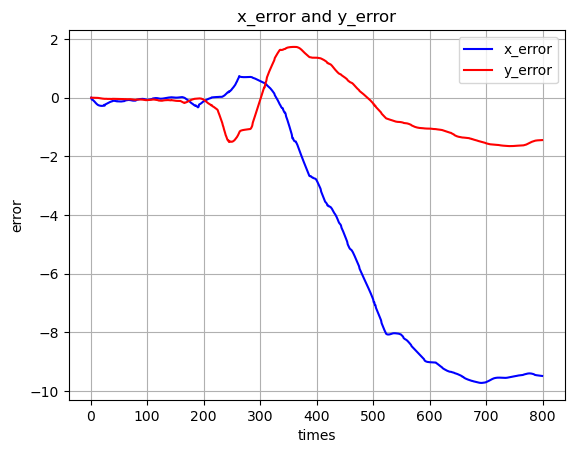

In [176]:
plt.plot(range(1,len(x_error_list)+1),x_error_list,"b",label = "x_error")
plt.plot(range(1,len(y_error_list)+1),y_error_list,"r",label = "y_error")
plt.title("x_error and y_error")
plt.xlabel("times")
plt.ylabel("error")
plt.legend()
plt.grid()
plt.show()

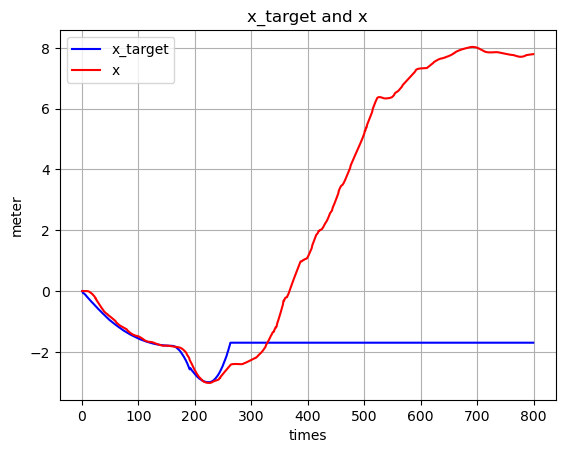

In [177]:
plt.plot(range(1,len(x_target_list)+1),x_target_list,"b",label = "x_target")
plt.plot(range(1,len(x_list)+1),x_list,"r",label = "x")
plt.title("x_target and x")
plt.xlabel("times")
plt.ylabel("meter")
plt.legend()
plt.grid()
plt.show()

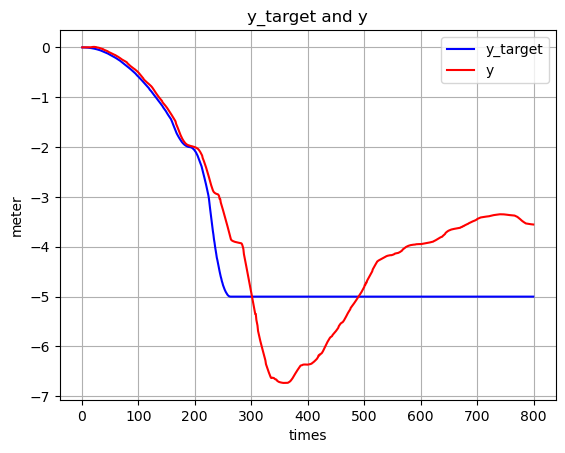

In [178]:
plt.plot(range(1,len(y_target_list)+1),y_target_list,"b",label = "y_target")
plt.plot(range(1,len(y_list)+1),y_list,"r",label = "y")
plt.title("y_target and y")
plt.xlabel("times")
plt.ylabel("meter")
plt.legend()
plt.grid()
plt.show()

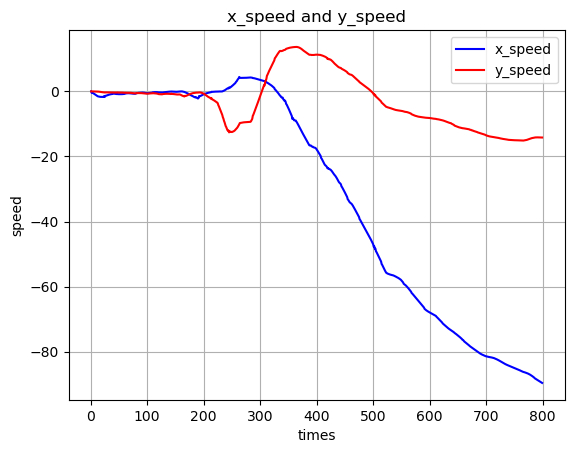

In [179]:
plt.plot(range(1,len(x_speed_list)+1),x_speed_list,"b",label = "x_speed")
plt.plot(range(1,len(y_speed_list)+1),y_speed_list,"r",label = "y_speed")
plt.title("x_speed and y_speed")
plt.xlabel("times")
plt.ylabel("speed")
plt.legend()
plt.grid()
plt.show()

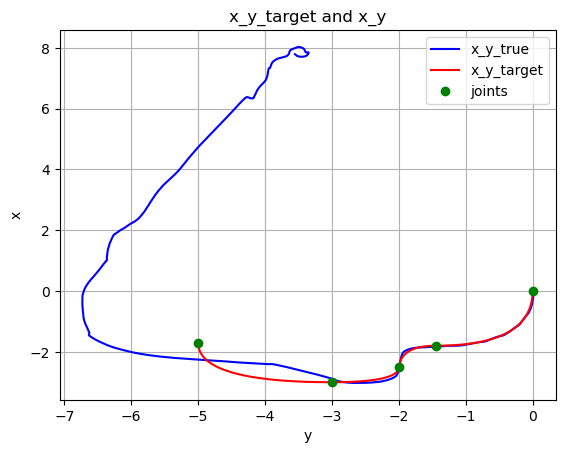

In [180]:
plt.plot(y_list,x_list,"b",label = "x_y_true")
plt.plot(y_target_list,x_target_list,"r",label = "x_y_target")
plt.plot(y_joints,x_joints,"go",label = "joints")
plt.title("x_y_target and x_y")
plt.xlabel("y")
plt.ylabel("x")
plt.legend()
plt.grid()
plt.show()